# Business Goal

Mobile carrier Megaline seeks to develop a model to analyze the cellphone behavior of legacy subscribers' in order to recommend them one of Megaline's newer plans: Smart or Ultra.
We will use behavior data about subscribers who have already switched to the new plans. The data has already been preprocessed. We will train several models and test them to find the best model that has the highest possible accuracy.
We aim to find a level of accuracy at or above 0.75. We will check the accuracy using a test dataset.

# Initializing Data

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [37]:
df = pd.read_csv('users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


The data contains 3214 records and 5 columns: 
  - сalls — number of calls,
  - minutes — total call duration in minutes,
  - messages — number of text messages,
  - mb_used — Internet traffic used in MB,
  - is_ultra — plan for the current month (Ultra - 1, Smart - 0).

There are no missing values.
All of the columns are float types except for is_ultra which is an integer type.

Even though the data has been preprocessed, we will convert the calls and messages data to an integer instead of a float.  Integers take up less memory so our model will process the data faster. Let's convert these columns to integers. We cannot convert the minutes and mb_used because the decimal data is may be helpful to train the model.

In [39]:
# Converting columns from float to integer types

df['calls'] = df['calls'].astype(int)
df['messages'] = df['messages'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int32(2), int64(1)
memory usage: 100.6 KB


In [40]:
# Checking for duplicates

duplicate = df[df.duplicated()]
duplicate

,calls,minutes,messages,mb_used,is_ultra


There are no duplicates in the dataframe.

# Developing Models
## Assigning the target variable
Our goal is to predict which plan to recommend to a legacy subscriber based on the new plans selected by users with similar behavior. We will assign is_ultra as our target variable and train our model to predict whether or not a user is on the ultra or smart plan.

In [41]:
# We will assign is_ultra as the target variable, the feature we need to predict, and the remaining attributes as the features.

features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

print(features.shape)
print(target.shape)

(3214, 4)
(3214,)


## Splitting the dataframe

We will split the users dataframe into 3 groups: a training set, a validation set, and a test set using the train_test_split function from sklearn. We need a validation set to evaluate each model's prediction accuracy. We will use a random_state parameter to randomly select the data for each set.

Since a separate test set does not exist the source data has to be split into three parts: training, validation, and test. We will leave as much data for the training as possible but make the sizes of the validation set and the test set equal. This will give us a source data split into a 3:1:1 ratio or  60% training, 20% validation, and 20% testing.

In [42]:
# Splitting data into 60% training dataset, 20% training dataset, 20% test dataset in two steps:
# First, we split data into 80% training and 20% test

df_train, df_test = train_test_split(df, test_size=0.20, random_state=12345)

features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(2571, 4)
(2571,)
(643, 4)
(643,)


In [43]:
# Then, we split data using a 0.25% test size for the validation set, effectively creating a 60% training dataset and a 20% validation dataset

df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=12345)

features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)


## Training Different Models<a class="anchor" id="chapter1"></a>

We will investigate the quality of different models and simultaneously tune the hyperparameters. We will use functions to apply the model to the data and use different hyperparameters for each iteration. This will inform us of the best hyperparameters to use with the best model. We will use the fit() method for training, and the predict() method for testing. We will use the accuracy_score() function to check the accuracy of each model.

### DecisionTreeClassifier Model

In [44]:
# Developing a model with DecisionTreeClassifier
 
best_model = None
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_result = result
        
print("max_depth =", depth)
print("Accuracy of the best model on the validation set:", best_result)

max_depth = 5
Accuracy of the best model on the validation set: 0.7013996889580093


### RandomForestClassifier Model

In [45]:
# Developing a model with RandomForestClassifier

best_score = 0
best_est = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators= est)
    model.fit(features_train, target_train)
    score = model.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est
 
print("Accuracy of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))

Accuracy of the best model on the validation set (n_estimators = 10): 0.7884914463452566


### LogisticRegression Model

In [46]:
# Developing a model with LogisticRegression

model =  LogisticRegression(random_state=12345, solver='liblinear') 
model.fit(features_train, target_train)
score_train = model.score(features_train, target_train)
score_valid = model.score(features_valid, target_valid)
 
print(
    "Accuracy of the logistic regression model on the training set:",
    score_train,
)
print(
    "Accuracy of the logistic regression model on the validation set:",
    score_valid,
)

Accuracy of the logistic regression model on the training set: 0.7028008298755186
Accuracy of the logistic regression model on the validation set: 0.6998444790046656


For the Logistic Regression Model the accuracy of the validation is slightly lower than the training set so there is a little overfitting within this model.

### Selecting Best Model

The RandomForestClassifier had the highest accuracy level at 79% with n_estimators = 10 so we will use this to assess our model using the test set. It makes sense this is the highest level accuracy since it uses several trees as opposed to one tree with the DecisionTreeClassifier (accuracy level around 77%).

### Assess the Model Using a Test Set
We will check quality of the RandomForestClassifier model we trained using the test set.

In [47]:
# Checking the quality of the RandomForestClassifier model using the test set.

model = RandomForestClassifier(random_state=12345, n_estimators= 10)
model.fit(features_train, target_train)
score = model.score(features_test, target_test)
score

0.7869362363919129

The accuracy of our model was 79% using our test set so the model is effective at predicting a plan based on users' behavior. We obtained a model with an accuracy level above 75%! Our accuracy is 0.786 compared to 0.788 for the model using the validation data so there model is not overfitting.

# Model Sanity Check
Since our task is to classify users into the ultra or smart plan, which is a binary task, the model's chance of being correct when predicting a plan randomly is 50%. It could be that our model has a 79% accuracy because there are few instances of one class, and this is why the accuracy of our model is better than 50%. We need a performance metric that takes into account class imbalances. Let's look at the ratio of instances where is_ultra is 1 and 0 to see if there is an imbalance of classes. We will use a confusion matrix to check if the accuracy of our model is due to the fact that the model is predicting one plan disproportionately over the other plan.

In [48]:
# Checking the value counts of the target variable in the source dataset

df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

There is an imbalance in the instances of 1 and 0 in is_ultra. There are 30% ultra users and 70% smart users.

In [49]:
target_pred = model.predict(features_test)

In [50]:
acc = model.score(features_test, target_test)
acc

0.7869362363919129

In [51]:
# Calculating a confusion matrix

conf_matrix = metrics.confusion_matrix(target_test, target_pred)

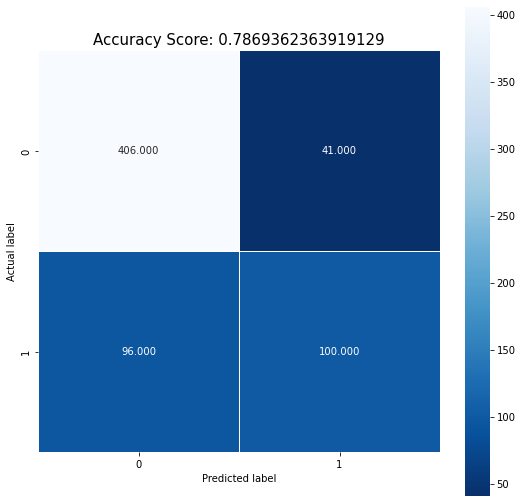

In [54]:
# Plotting a confusion matrix

plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title(all_sample_title, size = 15);

We can see from the confusion matrix that the classifier is not classifying every user as on one plan so it looks like the model is effectively predicting a plan for each user based on the user behavior.

# General Conclusion

We will use behavior data about subscribers who have already switched to the new plans: Smart or Ultra in order to recommend legacy subscribers on of Megaline’s newer plans. We trained several models and test them to find the best model that has the highest possible accuracy.

data contained 3214 records and 5 columns: 
  - сalls — number of calls,
  - minutes — total call duration in minutes,
  - messages — number of text messages,
  - mb_used — Internet traffic used in MB,
  - is_ultra — plan for the current month (Ultra - 1, Smart - 0).

There were no missing values. All of the columns are float types except for is_ultra which is an integer type.
Even though the data has been preprocessed, we converted the calls and messages data to an integer instead of a float.  Integers take up less memory making the model process the data faster.

There were no duplicates in the dataframe.

After preprocessing the data, we split the data into three groups. We needed a validation set to evaluate each model's prediction accuracy. Since a separate test set does not exist the source data has to be split into three parts: training, validation, and test. We will leave as much data for the training as possible but make the sizes of the validation set and the test set equal. This will give us a source data split into a 3:1:1 ratio or  60% training, 20% validation, and 20% testing.

We investigated the quality of different models and simultaneously tuned the hyperparameters using three models from sklearn and the best model of each type provided the following levels of accuracy:
  - DecisionTreeClassifier, 0.77
  - RandomForestClassifier, 0.79
  - LogisticRegression, 0.70

The most accurate model was the RandomForestClassifer. The accuracy for the test set was also 0.79 so overfitting was not an issue.

We performed a model sanity check using a confusion matrix and demonstrated that the model did not simply predict one class over another in a disproportionate way. The results were better than random prediction, indicating that the model effectively predicted a user’s plan 79% of the time.